# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [214]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [215]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [216]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [217]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [218]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [219]:
azdias.shape

(891221, 85)

In [220]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

    Here we already see, that some variables have many missing values

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [221]:
feat_info.missing_or_unknown.sum() #summarizing the attributes for missing values in the dataset

'[-1,0][-1,0,9][-1,0][0][-1][-1][-1][-1][-1][-1][-1][0][][][-1,0][0][0][0][0][0][0][-1,0][-1,0][0][-1,9][-1,9][-1,9][-1,9][-1,9][-1,9][-1,9][-1,9][-1,9][-1,9][-1,9][-1,9][-1,9][-1,9][-1][-1][-1,0][-1][-1,9][0][][][-1,0][-1][-1,0][-1,0][0][][-1,0][][0][-1][-1][-1,X][XX][-1,XX][-1][-1][-1][-1][-1,0][-1,0][-1][-1][-1][][-1,0][][][-1,0][][-1][-1][-1][-1][-1,0][-1][-1][-1,9][-1,0][-1,9]'

In [222]:
azdias.isnull().sum().sum() #summarizing values that are null without harmonizing the null values

4896838

    Clearing the datatset with regard to different null values:

In [223]:
for i in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[i]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip(']')
    missing_or_unknown = missing_or_unknown.split(sep=',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[i]['attribute']: missing_or_unknown}, np.nan)

In [224]:
azdias.isnull().sum().sum() # the real sum of the null values in the dataset

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [225]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
def get_pc_missing(df):
    num = df.isnull().sum()
    den = len(df)
    return 100*(num/den)



In [226]:
# Investigate patterns in the amount of missing data in each column.
get_pc_missing(azdias).sort_values(ascending=False)


TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

    Based on the above calculations, I suggest removing all columns that have more than 40% missing values. 

In [227]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias = azdias.drop(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR'],axis=1)


In [228]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

    I decided to remove all the columns that had more than 40% missing values. Overall there were five 
    variables having more than 40% missing values: 'TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR'.

    'TITEL_KZ' - Academic title flag - almost 100% missing; 
    'AGER_TYP' - Best-ager typology - almost 77% missing;
    'KK_KUNDENTYP' - Consumer pattern over past 12 months -  66% missing
    'KBA05_BAUMAX' - Most common building type within the microcell - 53% missing
    'GEBURTSJAHR' - Year of birth - missing 44%;





#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [229]:
# How much data is missing in each row of the dataset?
missing_rows = azdias.isnull().sum(axis=1)


In [230]:
missing_rows.nlargest(20) #largest missing values for each row

643174    49
732775    49
11        48
14        48
17        48
24        48
48        48
54        48
69        48
75        48
97        48
99        48
103       48
108       48
112       48
133       48
137       48
144       48
154       48
163       48
dtype: int64

Text(0,0.5,'rows')

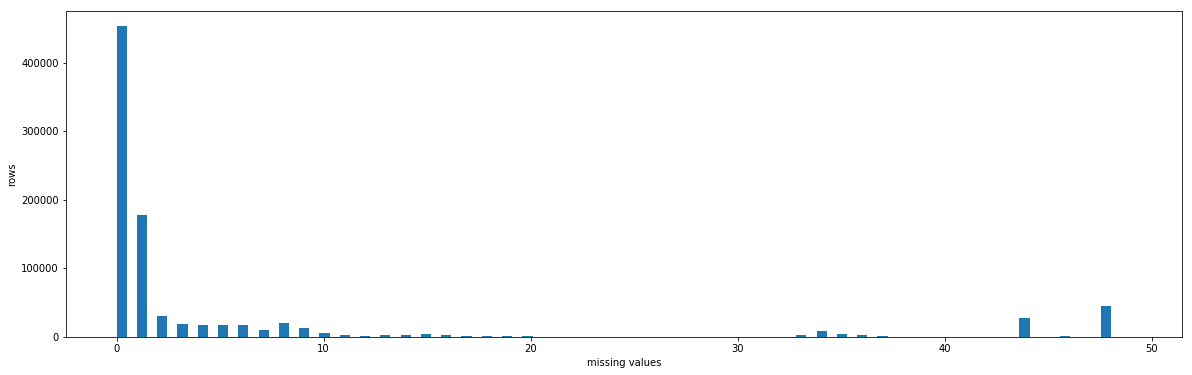

In [231]:
plt.figure(figsize=(20,6))
plt.hist(missing_rows, bins=100)
plt.xlabel('missing values')
plt.ylabel('rows')


    Based on this graph I suggest making treshold by 20 missing values

In [232]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Adding missing values count for each row to the dataset
azdias["missing_rows"] = missing_rows
azdias.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_rows
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0


In [233]:
azdias_a = azdias[azdias.isnull().sum(axis=1) < 20] #few missing values in a row
azdias_a.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_rows
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0


In [234]:
azdias_b = azdias[azdias.isnull().sum(axis=1) >= 20] # many missing values in a row
azdias_b.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_rows
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48
24,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48


In [235]:
columns = azdias_a.columns
percent_missing = azdias_a.isnull().sum() * 100 / len(azdias_a)
missing_value_a = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

In [236]:
missing_value_a.sort_values(by='percent_missing')

,column_name,percent_missing
missing_rows,missing_rows,0.000000
ANZ_TITEL,ANZ_TITEL,0.000000
SEMIO_SOZ,SEMIO_SOZ,0.000000
SEMIO_FAM,SEMIO_FAM,0.000000
SEMIO_REL,SEMIO_REL,0.000000
SEMIO_MAT,SEMIO_MAT,0.000000
SEMIO_VERT,SEMIO_VERT,0.000000
SEMIO_LUST,SEMIO_LUST,0.000000
HH_EINKOMMEN_SCORE,HH_EINKOMMEN_SCORE,0.000000
SEMIO_ERL,SEMIO_ERL,0.000000


In [237]:
columns = azdias_b.columns # many rows missing
percent_missing = azdias_b.isnull().sum() * 100 / len(azdias_b)
missing_value_b = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

In [238]:
missing_value_b.sort_values(by='percent_missing')

,column_name,percent_missing
missing_rows,missing_rows,0.000000
SEMIO_SOZ,SEMIO_SOZ,0.000000
SEMIO_MAT,SEMIO_MAT,0.000000
SEMIO_VERT,SEMIO_VERT,0.000000
SEMIO_LUST,SEMIO_LUST,0.000000
SEMIO_ERL,SEMIO_ERL,0.000000
SEMIO_KULT,SEMIO_KULT,0.000000
SEMIO_RAT,SEMIO_RAT,0.000000
SEMIO_KRIT,SEMIO_KRIT,0.000000
SEMIO_DOM,SEMIO_DOM,0.000000


In [239]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

In [240]:
def compare_datasets (df1, df2, column):
    fig, ax = plt.subplots(1,2)
    sns.countplot(df1[column], ax = ax[0])
    sns.countplot(df2[column], ax = ax[1])
    plt.subplots_adjust(wspace = 0.7)
    fig.show()
    return

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


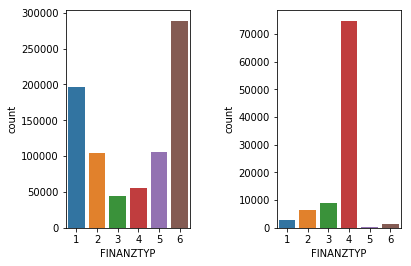

In [241]:
compare_datasets (azdias_a, azdias_b, 'FINANZTYP')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


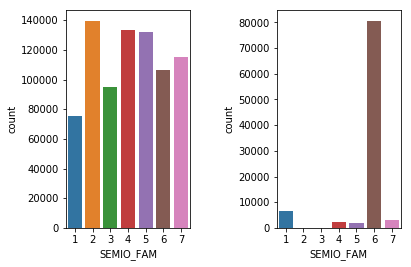

In [242]:
compare_datasets (azdias_a, azdias_b, 'SEMIO_FAM')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


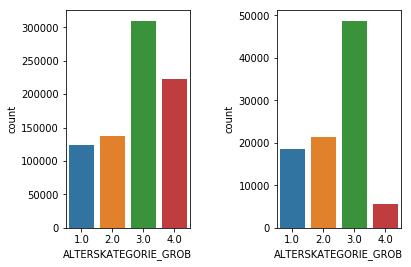

In [243]:
compare_datasets (azdias_a, azdias_b, 'ALTERSKATEGORIE_GROB')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


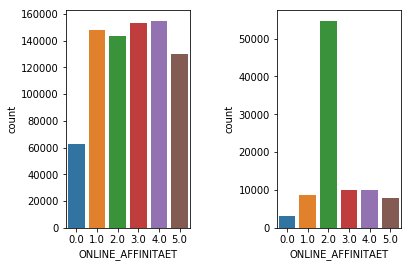

In [244]:
compare_datasets (azdias_a, azdias_b, 'ONLINE_AFFINITAET')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


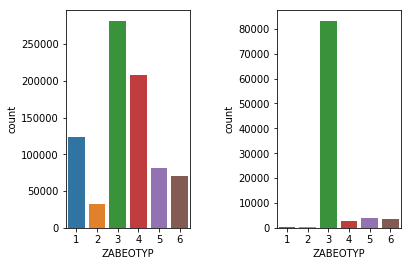

In [245]:
compare_datasets (azdias_a, azdias_b, 'ZABEOTYP')

#### Discussion 1.1.3: Assess Missing Data in Each Row

    Based on the comparison above we see that datasets with many missing rows (azdias_b) and 
    few missing rows(azidas_a) are different with regard to distribution of values. We don´t know the reason
    for missing values in those rows. However using them in further analysis could skew the results. 
    
    In order to mtitgate the risks coming from the data with many missing rows I will delete the rows which are missing more than 20 values in a row and perform further analysis only on the new dataset: azidas_new.


In [246]:
azdias_new = azdias[azdias.isnull().sum(axis=1) < 20] 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [247]:
# How many features are there of each data type?
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [248]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [249]:
cat_feat = feat_info[feat_info['type'] == 'categorical']
cat_feat

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [250]:
# Selecting features, that have more than two categories with a loop
nonbinary_features = []

for a in cat_feat.attribute:
    try:
        if azdias_new.loc[:,a].nunique() == 2:
            print("binary {} feature  ".format(azdias_new.loc[:,a].dtype), a)
        
        elif azdias_new.loc[:,a].nunique() > 2:
            nonbinary_features.append(a)
                       
       
            
    except: 
        print('Feature deleted')

Feature deleted
binary int64 feature   ANREDE_KZ
binary int64 feature   GREEN_AVANTGARDE
binary float64 feature   SOHO_KZ
Feature deleted
binary float64 feature   VERS_TYP
Feature deleted
binary object feature   OST_WEST_KZ


In [251]:
nonbinary_features

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

    After checking the variables in Data Dictionary I decided to additionaly drop two categorical variables due 
    to redundancy:'CAMEO_DEUG_2015', 'LP_FAMILIE_GROB'

In [252]:
azdias_new = azdias_new.drop(['CAMEO_DEUG_2015','LP_FAMILIE_GROB'],axis=1)

In [253]:
nonbinary_features.remove('CAMEO_DEUG_2015')

In [254]:
nonbinary_features.remove('LP_FAMILIE_GROB')

In [255]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Re-encoding Ost-West variable
azdias_new["OST_WEST_KZ"]= azdias_new["OST_WEST_KZ"].replace({"W": 1,"O":0})
azdias_new['OST_WEST_KZ'].unique()


array([1, 0])

In [256]:
azdias_new2 = pd.get_dummies(azdias_new, columns = nonbinary_features)

In [257]:
azdias_new2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features


           In the first step I verified what kind of categorical variables are present in the dataset. This step 
           was necessary in order to see what kind of actions are necessary (and possible) for each feature. 
      
           As a second step I deleted two redundant categorical variables and re-encoded one obejct feature.
    
           In the last step I made dummies out of the remaining categorical features.  
    


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [258]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_new2.PRAEGENDE_JUGENDJAHRE.head(10)


1     14.0
2     15.0
3      8.0
4      8.0
5      3.0
6     10.0
7      8.0
8     11.0
9     15.0
10     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [259]:
azdias_new2.PRAEGENDE_JUGENDJAHRE.value_counts()

14.0    182791
8.0     141395
10.0     85718
5.0      84644
3.0      53809
15.0     42465
11.0     35699
9.0      33558
6.0      25649
12.0     24434
1.0      20637
4.0      20450
2.0       7479
13.0      5754
7.0       4009
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [260]:
# Creating a generation variable out of PRAEGENDE_JUGENDJAHRE
generation_var = {0: [1, 2], 1: [3, 4], 2: [5, 6, 7], 3: [8, 9], 4: [10, 11, 12, 13], 5:[14, 15]}

def generation(x):
    try:
        for key, array in generation_var.items():
            if x in array:
                return key
    except ValueError:
        return np.nan
    

In [261]:
azdias_new2['PRAEGENDE_JUGENDJAHRE_GEN'] = azdias_new2['PRAEGENDE_JUGENDJAHRE'].apply(generation)

In [262]:
azdias_new2.PRAEGENDE_JUGENDJAHRE_GEN.value_counts()

5.0    225256
3.0    174953
4.0    151605
2.0    114302
1.0     74259
0.0     28116
Name: PRAEGENDE_JUGENDJAHRE_GEN, dtype: int64

In [263]:
# Creating mainstream feature out of PRAEGENDE_JUGENDJAHRE
mainstream_var = [1, 3, 5, 8, 10, 12, 14]

def mainstream(x):
    
        if x in mainstream_var:
            return 0
        else:
            return 1
    

In [264]:
azdias_new2['PRAEGENDE_JUGENDJAHRE_MAINS'] = azdias_new2['PRAEGENDE_JUGENDJAHRE'].apply(mainstream)

In [265]:
azdias_new2.PRAEGENDE_JUGENDJAHRE_MAINS.value_counts()

0    593428
1    203350
Name: PRAEGENDE_JUGENDJAHRE_MAINS, dtype: int64

In [266]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_new2.CAMEO_INTL_2015.value_counts()

51    133662
41     92293
24     91065
14     62830
43     56636
54     45362
25     39590
22     33123
23     26629
13     26305
45     26121
55     23927
52     20537
31     18950
34     18511
15     16964
44     14815
12     13226
35     10348
32     10345
33      9923
Name: CAMEO_INTL_2015, dtype: int64

In [267]:
# Engineering wealth feature out of CAMEO_INTL_2015_WEALTH
def wealth(x):
    try:
        return int(x) // 10
    except ValueError:
        return np.nan
    

In [268]:
azdias_new2['CAMEO_INTL_2015_WEALTH'] = azdias_new2['CAMEO_INTL_2015'].apply(wealth)

In [269]:
azdias_new2.CAMEO_INTL_2015_WEALTH.value_counts()


5.0    223488
2.0    190407
4.0    189865
1.0    119325
3.0     68077
Name: CAMEO_INTL_2015_WEALTH, dtype: int64

In [270]:
# Engineering life_stage feature out of CAMEO_INTL_2015_WEALTH
def life_stage(x):
    try:
        return int(x) % 10
    except ValueError:
        return np.nan

In [271]:
azdias_new2['CAMEO_INTL_2015_LIFE_ST'] = azdias_new2['CAMEO_INTL_2015'].apply(life_stage)

In [272]:
azdias_new2.CAMEO_INTL_2015_LIFE_ST.value_counts()

1.0    244905
4.0    232583
3.0    119493
5.0    116950
2.0     77231
Name: CAMEO_INTL_2015_LIFE_ST, dtype: int64

In [273]:
# Drop the old features
azdias_new2 = azdias_new2.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

    In the first step I re-encoded the mixed feature "PRAEGENDE_JUGENDJAHRE" in two features: 
    PRAEGENDE_JUGENDJAHRE_GEN and PRAEGENDE_JUGENDJAHRE_MAINS.
    The first new feature contains parts of the old feature with regard to the generation.
    The second new feature contains values with regard to avantgarde vs. mainstream characteristisc. 
    
    In the second step I re-encoded the variable CAMEO_INTL_2015 and retained its values: life_stage and wealth.
    
    In the last step I dropped the old features and retained only the newly created ones.   
    
   

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [274]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
mixed_feat = feat_info[feat_info['type'] == 'mixed'] #checking how many mixed features are left
mixed_feat

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [275]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Deleting some other mixed features
azdias_new2 = azdias_new2.drop(['PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'], axis=1)

In [276]:
azdias_new2.WOHNLAGE.value_counts()

3.0    249500
7.0    169205
4.0    135840
2.0    100286
5.0     74250
1.0     43867
8.0     17334
0.0      6496
Name: WOHNLAGE, dtype: int64

In [277]:
# Re-engineering feature WOHNLAGE; it should contain only information, whether the area is poor or wealthy and
# no information whether it is rural

wohnlage_dict = {0: [0], 1: [1], 2: [2], 3: [3], 4: [4], 5:[5]}

def wohnlage(x):
    try:
        for key, array in wohnlage_dict.items():
            if x in array:
                return key
    except ValueError:
        return np.nan
    

In [278]:
azdias_new2['WOHNLAGE_A'] = azdias_new2['WOHNLAGE'].apply(wohnlage)

In [279]:
azdias_new2.WOHNLAGE_A.value_counts()

3.0    249500
4.0    135840
2.0    100286
5.0     74250
1.0     43867
0.0      6496
Name: WOHNLAGE_A, dtype: int64

In [280]:
azdias_new2 = azdias_new2.drop(['WOHNLAGE'], axis=1)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [281]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for i in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[i]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[')
        missing_or_unknown = missing_or_unknown.strip(']')
        missing_or_unknown = missing_or_unknown.split(sep=',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df_nm = df.replace({feat_info.iloc[i]['attribute']: missing_or_unknown}, np.nan)
    
    # remove selected columns and rows, ...
    
    df_new1 = df_nm.drop(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR'],axis=1)
    df_new = df_new1[df_new1.isnull().sum(axis=1) < 20] 
    df_missing = df_new1[df_new1.isnull().sum(axis=1) >= 20] #keeping tha dataframe azidas_b for further computations
    
    # select, re-encode, and engineer column values.
    df_new = df_new.drop(['CAMEO_DEUG_2015','LP_FAMILIE_GROB'],axis=1)
 
    
    df_new['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)
    df_new = pd.get_dummies(df_new, columns = nonbinary_features)
    
    df_new['PRAEGENDE_JUGENDJAHRE_GEN'] = df_new['PRAEGENDE_JUGENDJAHRE'].apply(generation)
    df_new['PRAEGENDE_JUGENDJAHRE_MAINS'] = df_new['PRAEGENDE_JUGENDJAHRE'].apply(mainstream)
    
    df_new['CAMEO_INTL_2015_WEALTH'] = df_new['CAMEO_INTL_2015'].apply(wealth)
    df_new['CAMEO_INTL_2015_LIFE_ST'] = df_new['CAMEO_INTL_2015'].apply(life_stage)
    
    df_new = df_new.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)
    
    df_new = df_new.drop(['PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'], axis=1)
    df_new['WOHNLAGE_A'] = df_new['WOHNLAGE'].apply(wohnlage)
    df_new = df_new.drop(['WOHNLAGE'], axis=1)
    
    return df_new, df_missing

    
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [282]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
get_pc_missing(azdias_new2).sort_values(ascending=False)


ALTER_HH                     28.823964
WOHNLAGE_A                   23.411665
REGIOTYP                      8.018796
KKK                           8.018796
W_KEIT_KIND_HH                7.364410
KBA05_ANTG1                   4.882790
MOBI_REGIO                    4.882790
KBA05_ANTG4                   4.882790
KBA05_ANTG3                   4.882790
KBA05_ANTG2                   4.882790
KBA05_GBZ                     4.882790
VERS_TYP                      4.557480
HEALTH_TYP                    4.557480
PRAEGENDE_JUGENDJAHRE_GEN     3.550173
PLZ8_ANTG1                    2.772290
PLZ8_ANTG2                    2.772290
PLZ8_ANTG3                    2.772290
PLZ8_ANTG4                    2.772290
PLZ8_HHZ                      2.772290
PLZ8_GBZ                      2.772290
KBA13_ANZAHL_PKW              1.481843
ANZ_HAUSHALTE_AKTIV           0.788551
CAMEO_INTL_2015_LIFE_ST       0.704839
CAMEO_INTL_2015_WEALTH        0.704839
RETOURTYP_BK_S                0.580714
ONLINE_AFFINITAET        

In [283]:
imputer = Imputer(strategy='median')
azdias_clean = imputer.fit_transform(azdias_new2)

In [284]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler() 
azdias_clean_scaled = scaler.fit_transform(azdias_clean)

### Discussion 2.1: Apply Feature Scaling

    For handling the missing values I applied the imputer with median option. The median option 
    seems to be better as  it is highly probable that some of the features in the dataset are not 
    normally distributed. 
    Fur such data median values are better measure than the mean. 
    
    For feature scaling I used the standard scaler as it is simply the most used method in similar cases. 
    

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [285]:
# Apply PCA to the data.
pca = PCA(random_state=45)
azdias_pca = pca.fit_transform(azdias_clean_scaled)


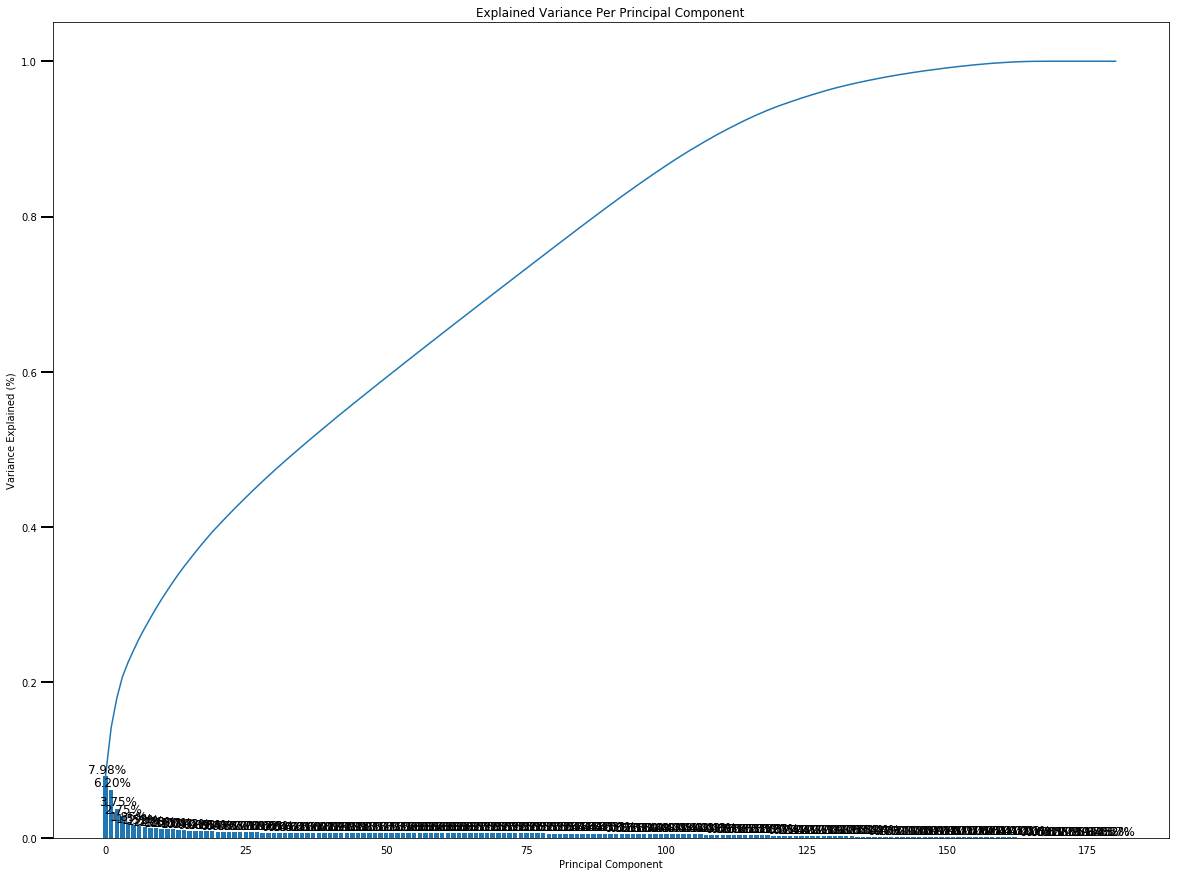

In [286]:
# Investigate the variance accounted for by each principal component.
# Scree plot from Udacity course
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 15))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

scree_plot(pca)


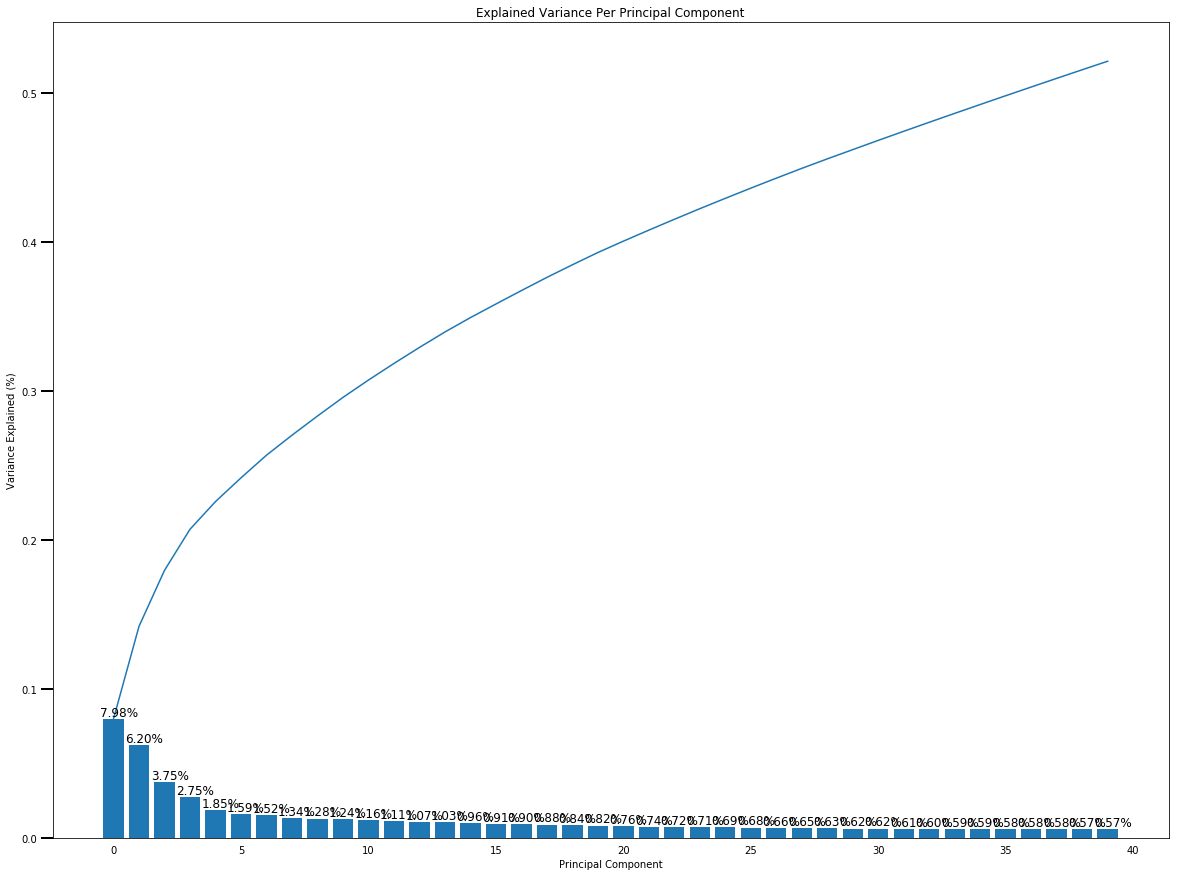

In [287]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 40)
azdias_pca = pca.fit_transform(azdias_clean_scaled)
scree_plot(pca)


### Discussion 2.2: Perform Dimensionality Reduction
    I decided to keep 40 components. 
    Reasons:
    - they explain well over 50% of the variance;
    - computational issues (computations with more components take too much time)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [288]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(azdias_new2.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights


In [289]:
pca_weight_first = pca_weights(pca, 0)
print(pca_weight_first.head(5))
print('\n')
print(pca_weight_first.tail(5))

LP_STATUS_GROB_1.0        0.200130
HH_EINKOMMEN_SCORE        0.185222
PLZ8_ANTG3                0.181488
CAMEO_INTL_2015_WEALTH    0.179645
PLZ8_ANTG4                0.176176
Name: 0, dtype: float64


KBA05_GBZ           -0.181283
PLZ8_ANTG1          -0.182267
KBA05_ANTG1         -0.189260
FINANZ_MINIMALIST   -0.205038
MOBI_REGIO          -0.205118
Name: 0, dtype: float64


In [290]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_second = pca_weights(pca, 1)

print(pca_weight_second.head(5))
print('\n')
print(pca_weight_second.tail(5))

ALTERSKATEGORIE_GROB    0.219610
FINANZ_VORSORGER        0.208344
ZABEOTYP_3              0.195886
SEMIO_ERL               0.172183
SEMIO_LUST              0.156063
Name: 1, dtype: float64


SEMIO_TRADV                 -0.197573
SEMIO_REL                   -0.201320
FINANZ_UNAUFFAELLIGER       -0.207995
FINANZ_SPARER               -0.211681
PRAEGENDE_JUGENDJAHRE_GEN   -0.229812
Name: 1, dtype: float64


In [291]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_third = pca_weights(pca, 2)
print(pca_weight_third.head(5))
print('\n')
print(pca_weight_third.tail(5))

SEMIO_VERT     0.321003
SEMIO_FAM      0.263807
SEMIO_SOZ      0.259088
SEMIO_KULT     0.255020
FINANZTYP_5    0.134522
Name: 2, dtype: float64


SEMIO_ERL    -0.210224
SEMIO_KRIT   -0.269157
SEMIO_DOM    -0.287563
SEMIO_KAEM   -0.318894
ANREDE_KZ    -0.348264
Name: 2, dtype: float64


### Discussion 2.3: Interpret Principal Components

    The first principal component seems to be associated with wealth and spending patterns.
    It positively correlates with:
    LP_STATUS_GROB_1.0 (social status), HH_EINKOMMEN_SCORE (income) and PLZ8_ANTG3 (not sure how to interpret this feature). 
    It negatively correlates with: 
    MOBI_REGIO (mobilty), FINANZ_MINIMALIST (low financial interest) and KBA05_ANTG1 (Number of 1-2 family houses in the microcell; not sure how to interpret this)
    

    The second principal component seems to be associated with personality traits and age/generation.
    However the correlations do not point in any clear direction.  
    It positively correlates with: ALTERSKATEGORIE_GROB (age), FINANZ_VORSORGER (financial conservative, ZABEOTYP_3  (energy consumption typology: fair supplied)
    It is negatively associated with: PRAEGENDE_JUGENDJAHRE_GEN (generation-age), FINANZ_UNAUFFAELLIGER and FINANZ_SPARER  (both types are also finacially conservative) and SEMIO_REL (religious person).
    
    
    The third principal component ist strongly associated with personality. It positively correlates 
    with social, family oriented family type and negatively correlated with 
    critical-minded event oriented personality traits.    
    Positive association with: SEMIO_VERT (personality typology: dreamful), SEMIO_FAM (personality typology: family-minded), SEMIO_SOZ(personaliyt typology: socially-minded)
    Negative association with with: SEMIO_ERL (event-oriented), SEMIO_KRIT (critical-minded) and SEMIO_DOM (dominant-minded)
    


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [292]:


# Over a number of different cluster counts...
scores_list = []


for cluster in range(3,15):
    
    # run k-means clustering on the data and...
    model = KMeans(n_clusters=cluster, random_state=45).fit(azdias_pca)
    
    # compute the average within-cluster distances.
    scores_list.append(np.abs(model.score(azdias_pca)))
    
 

Text(0.5,1,'Cluster and Scores')

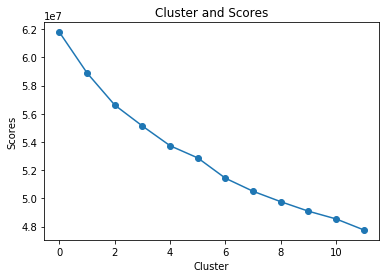

In [293]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(scores_list, linestyle='-', marker='o');
plt.xlabel('Cluster');
plt.ylabel('Scores');
plt.title('Cluster and Scores')


In [294]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 7, random_state=45)
model_7 = kmeans.fit(azdias_pca)
kmeans_azdias = model_7.predict(azdias_pca)


### Discussion 3.1: Apply Clustering to General Population

    Based on the above graph I decided to go with 7 clusters. The downward slope of the line in the graph seems
    to be less steep after it reaches 7 to 8 clusters. Another reason are the computational issues.
    With more cluster the computation time is much longer. 


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [295]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [296]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean, customers_missing = clean_data(customers)


In [297]:
customers_clean.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,PRAEGENDE_JUGENDJAHRE_GEN,PRAEGENDE_JUGENDJAHRE_MAINS,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_ST,WOHNLAGE_A
0,4,1,5,1,5,1,2,2,1,1,...,0,0,0,0,0,1.0,1,1.0,3.0,NaN
2,4,2,5,1,5,1,4,4,1,2,...,0,0,0,0,0,1.0,1,3.0,4.0,2.0
3,4,1,5,1,5,2,1,2,0,2,...,0,0,0,0,0,0.0,0,2.0,4.0,NaN
4,3,1,3,1,4,4,5,2,0,3,...,0,0,0,0,0,3.0,0,4.0,1.0,3.0
5,3,1,5,1,5,1,2,3,1,3,...,0,0,0,0,0,1.0,1,3.0,4.0,1.0


In [298]:
customers_clean1 = customers_clean.apply(lambda x:x.fillna(x.value_counts().index[0]))# replacing Nan values with zeroes

In [299]:
customers_clean1.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,PRAEGENDE_JUGENDJAHRE_GEN,PRAEGENDE_JUGENDJAHRE_MAINS,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_ST,WOHNLAGE_A
0,4,1,5,1,5,1,2,2,1,1,...,0,0,0,0,0,1.0,1,1.0,3.0,3.0
2,4,2,5,1,5,1,4,4,1,2,...,0,0,0,0,0,1.0,1,3.0,4.0,2.0
3,4,1,5,1,5,2,1,2,0,2,...,0,0,0,0,0,0.0,0,2.0,4.0,3.0
4,3,1,3,1,4,4,5,2,0,3,...,0,0,0,0,0,3.0,0,4.0,1.0,3.0
5,3,1,5,1,5,1,2,3,1,3,...,0,0,0,0,0,1.0,1,3.0,4.0,1.0


In [300]:
list(set(customers_clean1.columns) - set(azdias_new2))# verying which features are different in the datasets

['SHOPPER_TYP_3',
 'CAMEO_DEU_2015_XX',
 'NATIONALITAET_KZ_2',
 'NATIONALITAET_KZ_1',
 'NATIONALITAET_KZ_3',
 'SHOPPER_TYP_0',
 'NATIONALITAET_KZ_0',
 'LP_FAMILIE_FEIN_0.0',
 'SHOPPER_TYP_-1',
 'SHOPPER_TYP_2',
 'SHOPPER_TYP_1']

In [301]:
customers_clean1.shape # checking the shape of the dataset (it should be the same as azdias_new2)

(141690, 183)

In [302]:
azdias_new2.shape 

(796778, 181)

    The shape is different. I will have to drop some features from customers dataset

In [303]:
customers_clean2 = customers_clean1.drop(['CAMEO_DEU_2015_XX'], axis=1) 

In [304]:
customers_clean2.shape

(141690, 182)

In [305]:
list(set(customers_clean2.columns) - set(azdias_new2))

['SHOPPER_TYP_3',
 'NATIONALITAET_KZ_2',
 'NATIONALITAET_KZ_1',
 'SHOPPER_TYP_0',
 'NATIONALITAET_KZ_3',
 'NATIONALITAET_KZ_0',
 'LP_FAMILIE_FEIN_0.0',
 'SHOPPER_TYP_-1',
 'SHOPPER_TYP_2',
 'SHOPPER_TYP_1']

In [306]:
customers_clean3 = customers_clean2.drop(['LP_FAMILIE_FEIN_0.0'], axis=1) 

In [307]:
customers_clean3.shape 

(141690, 181)

    I removed two features: 'LP_FAMILIE_FEIN_0.0', 'CAMEO_DEU_2015_XX'. 
    There are other variables in the dataset that measure similar traits. 
    Now we can proceed with further analysis. 

In [308]:
customers_imputer = imputer.transform(customers_clean3)

In [309]:
customers_scaled = scaler.transform(customers_imputer)

In [310]:
pca_customer = pca.transform(customers_scaled)

In [311]:
kmeans_customer = model_7.predict(pca_customer)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'Population Data')

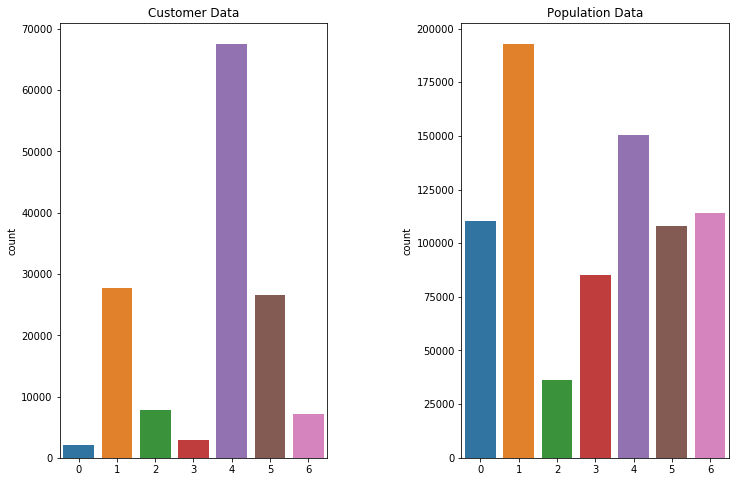

In [312]:
# First I visualise the overall data without computing proportions
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (12,8))
figure.subplots_adjust(hspace = 5, wspace=.5)

sns.countplot(kmeans_customer, ax=axs[0])
axs[0].set_title('Customer Data')
sns.countplot(kmeans_azdias, ax=axs[1])
axs[1].set_title('Population Data')

In [313]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Second: Visualising proportions with missing values

# Creating arrays with missing data for general population and customers data

# Creating cluster (-1) for dataset with many missing rows in general population 
azdias_many_missing = np.full((azdias_b.shape[0]), -1)
# Combining arrays: azdias with many missing values and without
azdias_combined = np.concatenate([kmeans_azdias, azdias_many_missing])


In [314]:
# Creating cluster (-1) for missing data in customer population
customers_many_missing = np.full((customers_missing.shape[0],), -1) # customer data with many missing rows as an array
# Combining arrays: customers with many missing values and without
customers_combined  = np.concatenate([kmeans_customer, customers_many_missing])

In [315]:
# Calculating proportions for datasets

population_dictionary = {'proportion': pd.Series(azdias_combined).value_counts(normalize=True, sort=False), 
          'data': 'population'}

population_prop = pd.DataFrame(population_dictionary)


customers_dictionary = {'proportion': pd.Series(customers_combined).value_counts(normalize=True, sort=False), 
          'data': 'customers'}

customer_prop = pd.DataFrame(customers_dictionary)

# Concatenate proportions
general_prop = pd.concat([population_prop, customer_prop])

In [316]:
general_prop.head() 

,proportion,data
0,0.123640,population
1,0.216528,population
2,0.040511,population
3,0.095827,population
4,0.168660,population


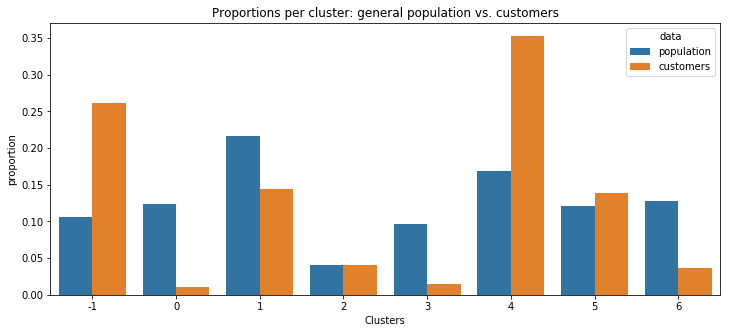

In [317]:
fig, ax = plt.subplots(figsize = (12,5))
sns.barplot(ax = ax, x = general_prop.index, y = general_prop.proportion, hue = general_prop.data)
ax.set_xlabel('Clusters')
ax.set_title('Proportions per cluster: general population vs. customers');

In [318]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

    Cluster 4 seems to be overrepresented in the customers dataset.

In [319]:
# Applying inverse_transform method
cluster4_data = scaler.inverse_transform(pca.inverse_transform(pca_customer[np.where(kmeans_customer==4)])).round()
cluster4_df = pd.DataFrame(data = cluster4_data, index = np.array(range(0, cluster4_data.shape[0])), columns = customers_clean3.columns)

cluster4_df.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_GEN,PRAEGENDE_JUGENDJAHRE_MAINS,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_ST,WOHNLAGE_A
0,3.0,1.0,5.0,1.0,5.0,1.0,3.0,2.0,0.0,2.0,...,-0.0,0.0,-0.0,-0.0,0.0,1.0,1.0,1.0,3.0,2.0
1,3.0,1.0,5.0,1.0,5.0,1.0,1.0,3.0,0.0,2.0,...,-0.0,-0.0,-0.0,-0.0,0.0,2.0,0.0,2.0,4.0,3.0
2,3.0,1.0,5.0,1.0,5.0,2.0,2.0,2.0,0.0,2.0,...,-0.0,-0.0,-0.0,-0.0,0.0,2.0,0.0,2.0,3.0,2.0
3,3.0,1.0,5.0,1.0,4.0,2.0,3.0,2.0,0.0,1.0,...,-0.0,0.0,-0.0,-0.0,0.0,2.0,1.0,1.0,4.0,2.0
4,3.0,1.0,5.0,2.0,3.0,3.0,3.0,1.0,0.0,2.0,...,-0.0,-0.0,-0.0,0.0,-0.0,3.0,0.0,2.0,2.0,2.0
5,3.0,1.0,4.0,2.0,3.0,3.0,3.0,2.0,0.0,2.0,...,-0.0,0.0,-0.0,0.0,0.0,3.0,0.0,4.0,3.0,3.0
6,3.0,2.0,3.0,2.0,4.0,3.0,3.0,3.0,0.0,2.0,...,-0.0,0.0,-0.0,-0.0,0.0,2.0,0.0,2.0,4.0,3.0
7,4.0,1.0,5.0,1.0,4.0,2.0,3.0,1.0,0.0,1.0,...,-0.0,-0.0,-0.0,-0.0,0.0,2.0,1.0,2.0,3.0,3.0
8,2.0,2.0,4.0,2.0,4.0,3.0,2.0,2.0,0.0,2.0,...,-0.0,0.0,0.0,-0.0,-0.0,2.0,0.0,1.0,5.0,2.0
9,4.0,2.0,4.0,2.0,4.0,3.0,3.0,3.0,0.0,1.0,...,-0.0,-0.0,-0.0,-0.0,0.0,2.0,0.0,3.0,3.0,3.0


In [320]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

    Most underrepresented clusters are 0 and 6.

In [324]:
# Applying inverse_transform method
cluster0_data = scaler.inverse_transform(pca.inverse_transform(pca_customer[np.where(kmeans_customer==0)])).round()
cluster0_df = pd.DataFrame(data = cluster0_data, index = np.array(range(0, cluster0_data.shape[0])), columns = customers_clean3.columns)

cluster0_df.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_GEN,PRAEGENDE_JUGENDJAHRE_MAINS,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_ST,WOHNLAGE_A
0,4.0,2.0,2.0,4.0,2.0,4.0,4.0,3.0,0.0,2.0,...,-0.0,0.0,0.0,-0.0,-0.0,4.0,1.0,3.0,4.0,2.0
1,2.0,2.0,3.0,3.0,3.0,3.0,2.0,4.0,0.0,1.0,...,-0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,2.0,4.0
2,2.0,2.0,2.0,4.0,3.0,3.0,3.0,4.0,-0.0,2.0,...,-0.0,0.0,0.0,-0.0,-0.0,4.0,0.0,3.0,1.0,3.0
3,3.0,2.0,2.0,4.0,2.0,4.0,4.0,3.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,3.0,3.0
4,2.0,2.0,3.0,2.0,4.0,3.0,2.0,5.0,0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,2.0,1.0,4.0,1.0,4.0
5,3.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,2.0,...,-0.0,0.0,0.0,0.0,0.0,3.0,1.0,3.0,4.0,3.0
6,3.0,2.0,2.0,4.0,3.0,3.0,4.0,4.0,0.0,2.0,...,-0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,4.0,3.0
7,2.0,2.0,2.0,3.0,4.0,3.0,3.0,5.0,-0.0,2.0,...,-0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,1.0,3.0
8,2.0,2.0,2.0,2.0,3.0,3.0,3.0,5.0,0.0,-0.0,...,-0.0,-0.0,0.0,-0.0,-0.0,1.0,1.0,5.0,4.0,4.0
9,1.0,2.0,2.0,3.0,3.0,4.0,3.0,4.0,0.0,2.0,...,-0.0,0.0,0.0,-0.0,0.0,3.0,0.0,3.0,3.0,3.0


In [325]:
cluster6_data = scaler.inverse_transform(pca.inverse_transform(pca_customer[np.where(kmeans_customer==6)])).round()
cluster6_df = pd.DataFrame(data = cluster6_data, index = np.array(range(0, cluster6_data.shape[0])), columns=customers_clean3.columns)

cluster6_df.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_GEN,PRAEGENDE_JUGENDJAHRE_MAINS,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_ST,WOHNLAGE_A
0,2.0,1.0,5.0,2.0,4.0,3.0,2.0,1.0,0.0,2.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,3.0,0.0,1.0,2.0,2.0
1,2.0,1.0,5.0,3.0,2.0,2.0,5.0,0.0,0.0,2.0,...,0.0,0.0,-0.0,-0.0,0.0,4.0,1.0,1.0,1.0,2.0
2,2.0,1.0,4.0,3.0,2.0,3.0,4.0,1.0,0.0,2.0,...,-0.0,-0.0,0.0,0.0,-0.0,4.0,0.0,2.0,5.0,3.0
3,2.0,1.0,5.0,2.0,3.0,2.0,3.0,1.0,0.0,2.0,...,-0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,2.0,3.0
4,3.0,1.0,2.0,5.0,1.0,5.0,5.0,2.0,0.0,2.0,...,-0.0,0.0,-0.0,0.0,0.0,5.0,1.0,4.0,3.0,2.0
5,3.0,1.0,4.0,2.0,3.0,2.0,3.0,1.0,0.0,3.0,...,0.0,-0.0,-0.0,-0.0,-0.0,4.0,0.0,2.0,2.0,2.0
6,3.0,2.0,3.0,5.0,1.0,5.0,5.0,1.0,1.0,2.0,...,-0.0,0.0,0.0,0.0,-0.0,5.0,1.0,3.0,2.0,3.0
7,3.0,1.0,5.0,3.0,3.0,3.0,3.0,-0.0,0.0,3.0,...,-0.0,0.0,0.0,-0.0,-0.0,4.0,1.0,2.0,4.0,2.0
8,2.0,1.0,5.0,2.0,3.0,2.0,3.0,1.0,0.0,1.0,...,0.0,-0.0,-0.0,-0.0,-0.0,3.0,0.0,1.0,3.0,3.0
9,2.0,1.0,5.0,3.0,2.0,3.0,4.0,1.0,0.0,2.0,...,-0.0,0.0,-0.0,0.0,0.0,4.0,0.0,2.0,2.0,3.0


### Discussion 3.3: Compare Customer Data to Demographics Data

    Overall the differences in distribution of data in the clusteres seems to be pretty even. 
    
    Cluster 4 is overrepresented in the customer data. Cluster 4 combines following characteristics:
    people with high financial interest, older than Millenials, living in good neigbourhoods,
    belonging to wealthier part of the population. 
    
    Cluster 0 and 6 are underepresented in the customer data. They seem to enclose less wealthy parts of the population due to the fact that both clusters contain people living in less good neighbourhoods than cluster 4. 
    In comparison to cluster 4 people in cluster 6 seem also to be younger. 
    

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.